# Spotify Classification System




## Introduction

For our project, we will be aiming to create a Spotify recommendation system. We will be using the `spotipy` package to download the data from Spotify and `scikit-learn` classification models to predict this. We will take 5 different playlists, with extremely different genres and analyse the features of the songs in the playlists and then separate them into 5 different categories. We will then attempt to classify some songs into each category or playlist using our model. 

The first thing we do is import our packages.

In [1]:
#%pip install spotipy
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

Note: you may need to restart the kernel to use updated packages.


In order to obtain the data on which we will be creating our model, we will import the `Spotipy` package. The Spotipy Application Programming Interface (API) will allow us to obtain dataset(s) containing information about public spotify playlists. Spotipy generates a client id and secret for each project, using which we can pull our data.

In [2]:
client_id = "ce4a8a04d596466ba2d6913fa58efd1a"
client_secret = "4c73051a80214e9ab5a9228da800af38"
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id = client_id,
                                                           client_secret=client_secret))

# Methods

The first step would be pulling the data we are looking for. Spotipy data comes with a plethora of different attributes. The main ones we will be looking at is those describing each specific track. These are known as audio features, and contain attributes such as Energy, Key, Loudness and many different features. As we are only looking at audio features and not other data such as markets available, artist information, album information, we will create a function `get_playlist_data` to pull the relevant information below. The function will return the information in the form of a `Pandas` dataframe.

In [3]:
def get_playlist_data(id):
    playlist = sp.playlist(id)
    tracks = playlist['tracks']['items']
    tracklist = [i['track'] for i in tracks]
    track_ids = [i['id'] for i in tracklist if i is not None]
    audio_features = sp.audio_features(track_ids)
    audio_info = {} 
    for af in audio_features:
        audio_info[af['id']] = [af['danceability'], \
                                                 af['energy'], \
                                                 af['key'], \
                                                 af['loudness'], \
                                                 af['mode'], \
                                                 af['speechiness'], \
                                                 af['acousticness'], \
                                                 af['instrumentalness'], \
                                                 af['liveness'], \
                                                 af['valence'], \
                                                 af['tempo'], \
                                                 af['duration_ms'], \
                                                 af['time_signature']]
    audio_info_df = pd.DataFrame.from_dict(audio_info).transpose()
    
    # rename the columns
    colnames = {0: "Danceability", 1: "Energy", 2: "Key", 3: "Loudness", 4: "Mode", 5: "Speechiness", 6: "Acousticness", 7: "Instrumentalness", 8: "Liveness", 9: "Valence", 10: "Tempo", 11 :"Duration", 12: "Time"}
    audio_info_df = audio_info_df.rename(columns = colnames)
    
    # drop the last columns
    audio_info_df = audio_info_df.drop(columns = 'Time')
    return audio_info_df

To train this model, we will be pulling data from 5 different playlists, each containing 100 songs, organized by genre.  

In [4]:
#pop 
playlist1 = get_playlist_data("3lro0N5fTyoXFZFbowlcdM")

#jazz
playlist2 = get_playlist_data("2YHUCJq5hBiNT6Qs5UXoqk")

#foreign language
playlist3 = get_playlist_data("7pzKNlgjgNetcKjtiTTSpa")

#country
playlist4 = get_playlist_data("5pkz9qj6Z5Qa9jZntGBgg4")

#gospel
playlist5 = get_playlist_data("37i9dQZF1DXcb6CQIjdqKy")

In [5]:
playlist1['Class'] = "Pop"
playlist2['Class'] = "Jazz"
playlist3['Class'] = "Foreign Language"
playlist4['Class'] = "Country"
playlist5['Class'] = "Gospel"

We want to plot out some attributes of the five different playlists to see how they compare to each other. Since all the attributes are numerical, we will plot out 5 different boxplots to compare them. For this analysis, we will specifically focus on Energy, Danceability, Acousticness and Liveness.

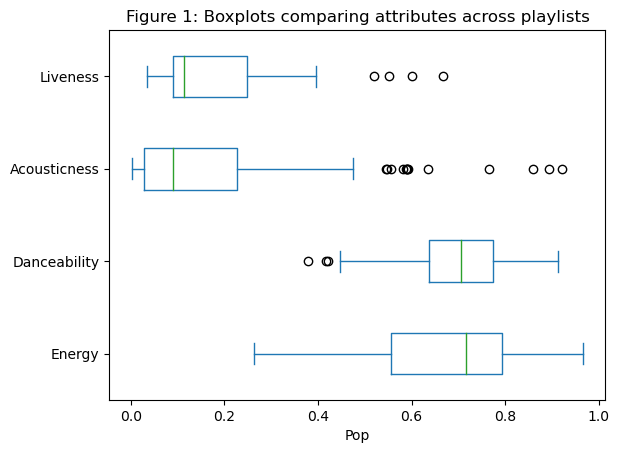

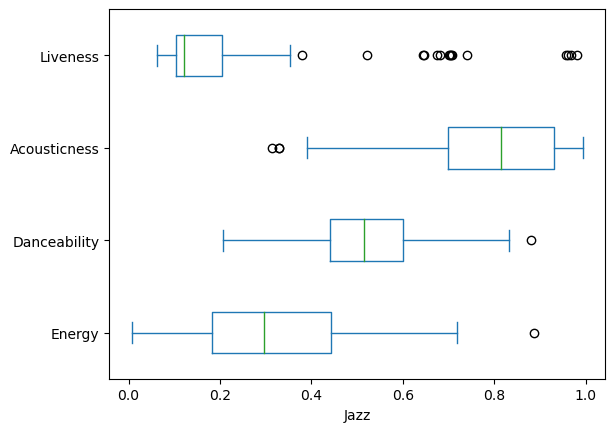

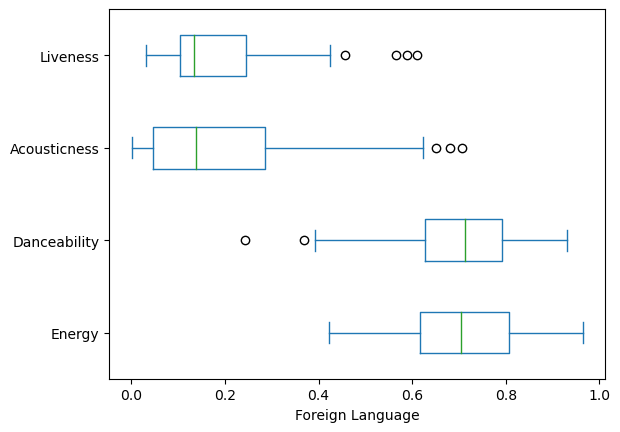

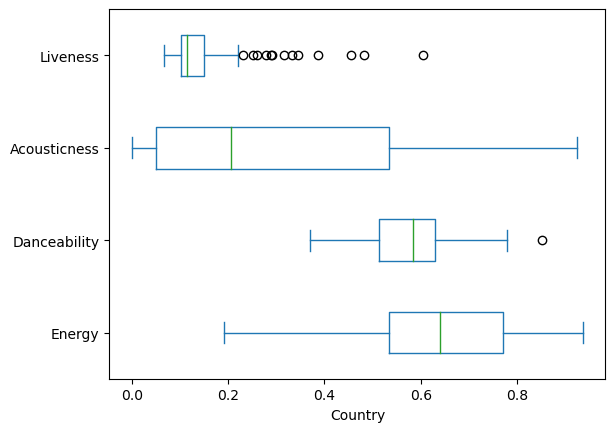

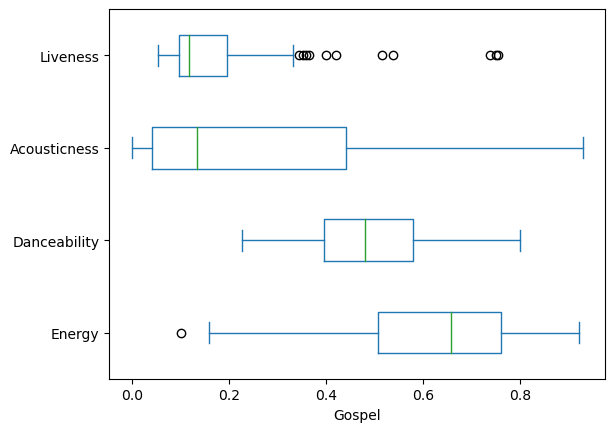

In [6]:
playlist1[['Energy', 'Danceability', 'Acousticness', 'Liveness']].plot(kind = 'box', vert = False, xlabel="Pop")
plt.title("Figure 1: Boxplots comparing attributes across playlists")
playlist2[['Energy', 'Danceability', 'Acousticness', 'Liveness']].plot(kind = 'box', vert = False, xlabel="Jazz")
playlist3[['Energy', 'Danceability', 'Acousticness', 'Liveness']].plot(kind = 'box', vert = False, xlabel="Foreign Language")
playlist4[['Energy', 'Danceability', 'Acousticness', 'Liveness']].plot(kind = 'box', vert = False, xlabel="Country")
playlist5[['Energy', 'Danceability', 'Acousticness', 'Liveness']].plot(kind = 'box', vert = False, xlabel="Gospel")
plt.show()

As we can see in the plots above, there are differences across genres for each attribute. For example, acousticness in Jazz is much higher than it is in Pop. This indicates to us that the different attributes can be used in our classification model. However, there is a lot of overlap between some genres. This makes sense as each genre consists of a wide range of songs, and they will overall have a large interquartile range.

The next step is to combine all the different datasets into one large one.

In [7]:
final_data = pd.concat([playlist1, playlist2, playlist3, playlist4, playlist5])
final_data.head()

Danceability  Energy   Key  Loudness  Mode  \
7fBv7CLKzipRk6EC6TWHOB         0.585   0.564   0.0    -7.063   0.0   
62yJjFtgkhUrXktIoSjgP2         0.448   0.784   9.0    -3.686   1.0   
7dt6x5M1jzdTEt8oCbisTK         0.680   0.578  10.0    -5.804   1.0   
5iNRPN7oYQvdB9AmeSW6d3         0.746   0.873   7.0    -3.803   1.0   
1ve0SgTZkv3wdggJLqtBYU         0.751   0.736   5.0    -4.168   0.0   

                        Speechiness  Acousticness  Instrumentalness  Liveness  \
7fBv7CLKzipRk6EC6TWHOB       0.0515        0.0671          0.000000     0.135   
62yJjFtgkhUrXktIoSjgP2       0.0627        0.1060          0.000108     0.668   
7dt6x5M1jzdTEt8oCbisTK       0.0400        0.3310          0.000000     0.135   
5iNRPN7oYQvdB9AmeSW6d3       0.1280        0.0244          0.000000     0.354   
1ve0SgTZkv3wdggJLqtBYU       0.1560        0.0206          0.000000     0.265   

                        Valence    Tempo  Duration Class  
7fBv7CLKzipRk6EC6TWHOB    0.137  113.003  242253.0   Pop  
62yJjFtgkhUrXktIoSjgP2    0.236  136.245  186813.0   Pop  
7dt6x5M1jzdTEt8oCbisTK    0.341  145.038  231267.0   Pop  
5iNRPN7oYQvdB9AmeSW6d3    0.817  148.075  222093.0   Pop  
1ve0SgTZkv3wdggJLqtBYU    0.352  130.014  262147.0   Pop

## Model Creation

To create the model, we'll first need to split the data into training and testing sets. We are setting the seed so that the model is reproducible and it does not generate new training and testing sets every time we run it.

We first considered using a logistic classifier as our model, but we decided that due to our classifier having 5 output classes, we would lose too much detail by using a linear model. Instead, we decided to use a decision tree model, which will retain enough detail to support non-linear output patterns, and so, is better for multiple output classes. The decision tree model is also easier to interpret than models such as random forests or neural networks. We also considered using K-nn classification, but as the data we are working with has a large number of predictor variables, we thought that using a nearest neighbours algorithm might yield confusing and inaccurate results.

In [8]:
""" split test/train data """
np.random.seed(2342)
from sklearn import model_selection,linear_model, tree, metrics, feature_selection, preprocessing
X = final_data.drop(columns = ["Class"])
y = final_data["Class"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [9]:
""" create a model and train it """
model = tree.DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

We want to then compare the predicted and actual classes, so we created a dataframe combining the two. We then created a new column to look at the number of correct predictions.

In [10]:
""" create table of predicted vs expected values from testing data """
predicted = pd.DataFrame(model.predict(X_test))
expected = pd.DataFrame(y_test)

In [11]:
expected = expected.reset_index()
expected.head()

data = expected.merge(predicted, left_index = True, right_index = True)
data = data.rename(columns = {0: 'Pred', 'Class': "Exp"})
data['Comparison'] = data['Exp'] == data['Pred']
data.head()

index               Exp              Pred  Comparison
0  3lcBpmaV7zkDtFzjzOB6GJ            Gospel           Country       False
1  2x91iJc0UkFcjRMEZ2CoWB              Jazz              Jazz        True
2  2DDde2GRAA9scMAMzXCFkU  Foreign Language           Country       False
3  3IX5wVQbXOLLlUcItVnb2i            Gospel  Foreign Language       False
4  5p6me2mwQrGfH30eExHn6v              Jazz              Jazz        True

Next, we will look at the prediction accuracy by counting the number of correct predictions/total predictions

In [12]:
prediction_accuracy = sum(data['Comparison']) / len(data['Comparison'])
print(prediction_accuracy)

0.536


In [13]:
predicted_probs = model.predict_proba(X_test)
auc = metrics.roc_auc_score(y_test, predicted_probs, multi_class = "ovr")
auc

0.7103100246065882

Our accuracy came to ~53% and the AUC is ~0.71. While these are not poor numbers, we want to see if we can improve this in any way. We are going to do feature selection using a Variance Threshold to see what the best predictors to use are. To do this, first we'll have to scale the dataset as the features of different ranges. From there, we find the variances of all the features.

In [14]:
norm = preprocessing.Normalizer().fit(X_train)
norm_X_train = norm.transform(X_train)
norm_X_train.var(axis = 0)

array([1.67515979e-12, 2.08949872e-12, 3.64669049e-10, 2.95489005e-10,
       5.44220674e-12, 1.93625718e-13, 2.13987904e-12, 3.75772039e-13,
       5.30970881e-13, 1.91572327e-12, 4.56072195e-08, 2.02439375e-14])

Since the variances are all quite low, with the lowest being to around $2e-14$, we will choose the threshold to be $5e-13$ and do feature selection. Variance Threshold removes all the predictors that are below the threshold set.

In [15]:
selector = feature_selection.VarianceThreshold(threshold = 5e-13)
selected_features = pd.DataFrame(selector.fit_transform(norm_X_train))
selected_features.var()

0    1.679663e-12
1    2.095116e-12
2    3.656493e-10
3    2.962833e-10
4    5.456836e-12
5    2.145631e-12
6    5.323982e-13
7    1.920873e-12
8    4.572982e-08
dtype: float64

Since we know the features are arranged in the same order as the dataframe, we know the features to drop are Speechiness, Instrumentalness and Duration. We will then train a new model with the remaining features.

In [16]:
np.random.seed(2342)
new_data = final_data.drop(columns = ['Speechiness', 'Instrumentalness', 'Duration'])
X_new = new_data.drop(columns = ["Class"])
y_new = new_data["Class"]
X_train_new, X_test_new, y_train_new, y_test_new = model_selection.train_test_split(X_new, y_new, test_size=0.25)

In [17]:
model_new = tree.DecisionTreeClassifier(random_state=0).fit(X_train_new, y_train_new)

predicted_new = pd.DataFrame(model_new.predict(X_test_new))
expected_new = pd.DataFrame(y_test_new)


expected_new = expected_new.reset_index()
expected_new.head()

data_new = expected_new.merge(predicted_new, left_index = True, right_index = True)
data_new = data_new.rename(columns = {0: 'Pred', 'Class': "Exp"})
data_new['Comparison'] = data_new['Exp'] == data_new['Pred']
data_new.head()

index               Exp     Pred  Comparison
0  3lcBpmaV7zkDtFzjzOB6GJ            Gospel  Country       False
1  2x91iJc0UkFcjRMEZ2CoWB              Jazz     Jazz        True
2  2DDde2GRAA9scMAMzXCFkU  Foreign Language      Pop       False
3  3IX5wVQbXOLLlUcItVnb2i            Gospel   Gospel        True
4  5p6me2mwQrGfH30eExHn6v              Jazz     Jazz        True

In [18]:
prediction_accuracy_new = sum(data_new['Comparison']) / len(data_new['Comparison'])

predicted_probs_new = model_new.predict_proba(X_test_new)
auc_new = metrics.roc_auc_score(y_test_new, predicted_probs_new, multi_class = "ovr")

print(prediction_accuracy_new)
print(auc_new)

0.552
0.7167766982526773


The accuracy has increased to ~55% and the AUC had a minimal increase. While this increase is not notably large, it is still a step up from the model with all the predictors. We will now visualize the Decision Tree as well as discuss why the model accuracy could be this low.

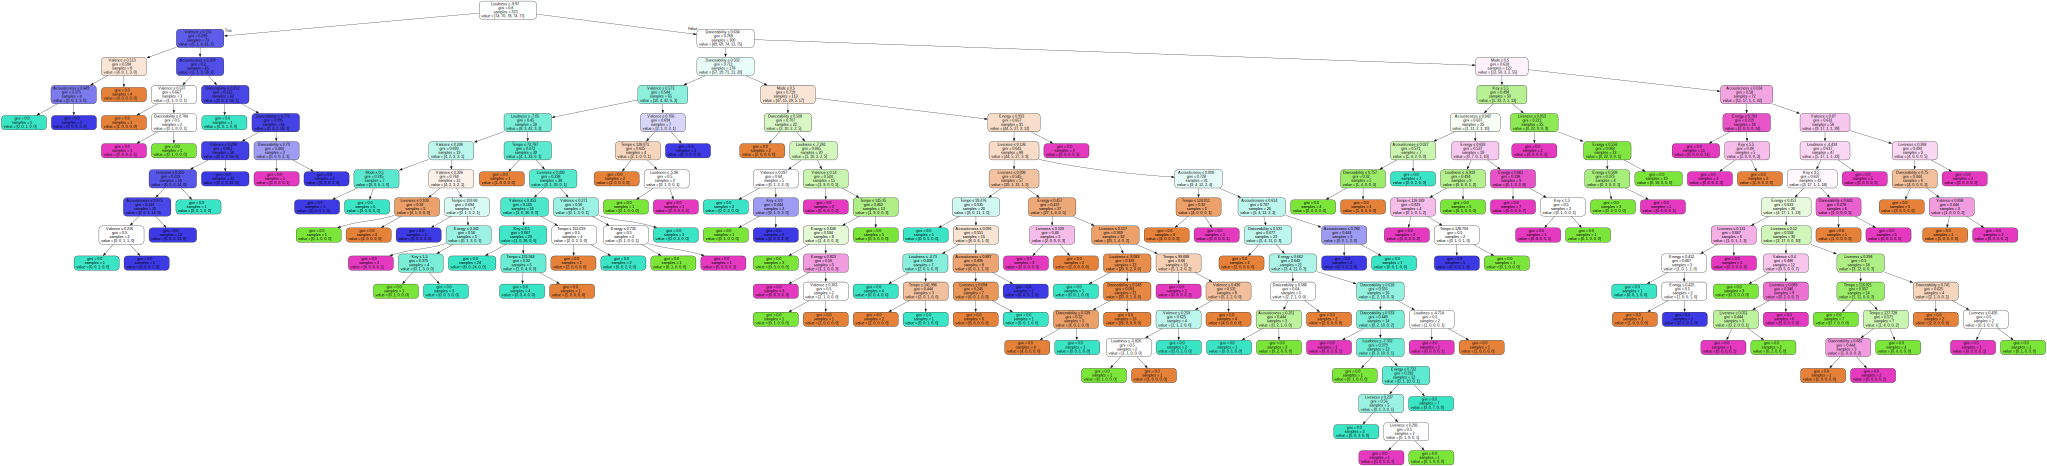

In [19]:
import graphviz
tree_graph = tree.export_graphviz(model_new, out_file=None,
                                  feature_names=X_test_new.columns,
                                  filled=True, rounded=True,
                                  special_characters=True, rotate = False)
graph = graphviz.Source(tree_graph)
filename =  graph.render(filename='img/fig1')
display(graph)

As we can easily see above, the graph has too many layers to be interpretable, as there are 9 predictors. Also something we noticed is that because we had not limited the number of layers in our model, there is the possibility that our model overfitted the data, which would lower the accuracy of our model. If we restrict the tree to have a maximum depth then we can potentially get a better accuracy.

In [20]:
model_2 = tree.DecisionTreeClassifier(random_state=0, max_depth = 5).fit(X_train_new, y_train_new)

predicted_2 = pd.DataFrame(model_2.predict(X_test_new))
expected_2 = pd.DataFrame(y_test_new)


expected_2 = expected_2.reset_index()
expected_2.head()

data_2 = expected_2.merge(predicted_2, left_index = True, right_index = True)
data_2 = data_2.rename(columns = {0: 'Pred', 'Class': "Exp"})
data_2['Comparison'] = data_2['Exp'] == data_2['Pred']
data_2.head()

index               Exp     Pred  Comparison
0  3lcBpmaV7zkDtFzjzOB6GJ            Gospel  Country       False
1  2x91iJc0UkFcjRMEZ2CoWB              Jazz     Jazz        True
2  2DDde2GRAA9scMAMzXCFkU  Foreign Language      Pop       False
3  3IX5wVQbXOLLlUcItVnb2i            Gospel   Gospel        True
4  5p6me2mwQrGfH30eExHn6v              Jazz     Jazz        True

In [21]:
prediction_accuracy_2 = sum(data_2['Comparison']) / len(data_2['Comparison'])

predicted_probs_2 = model_2.predict_proba(X_test_new)
auc_2 = metrics.roc_auc_score(y_test_new, predicted_probs_2, multi_class = "ovr")

print(prediction_accuracy_2)
print(auc_2)

0.624
0.8329703857474383


The new accuracy is significantly higher at ~62% and the AUC is also higher at 0.83.

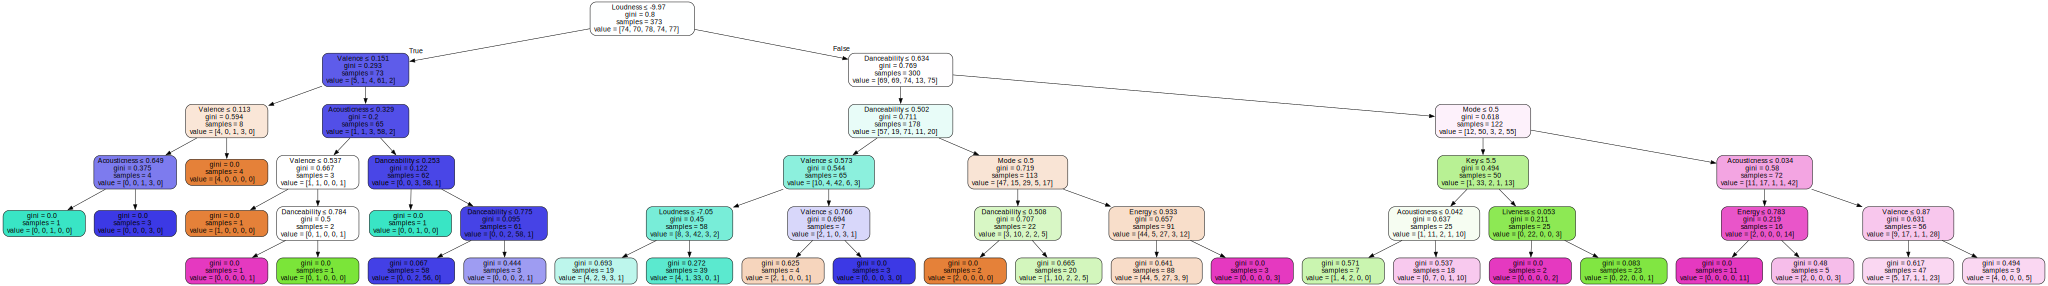

In [22]:
tree_graph2 = tree.export_graphviz(model_2, out_file=None,
                                  feature_names=X_test_new.columns,
                                  filled=True, rounded=True,
                                  special_characters=True, rotate = False)
graph2 = graphviz.Source(tree_graph2)
filename =  graph.render(filename='img/fig2')
display(graph2)

The graph above is much easier to interpret than our previous one, and shows us exactly what the decision tree classifier is doing. As for why our accuracy is not higher, it could be due to confounding factors affecting the classes. Despite the fact that each playlist is from a specific genre, there could be factors such as artist, markets that each playlist is available in, album length that affect a song being in a certain playlist. Songs can also be classified into multiple playlists, such as a foreign language song as well as pop, and so it is restrictive to say that they belong to only one single class. Another aspect that could be affecting the model accuracy is the fact that within genres, each attribute can very - for example a pop song could be both slow and fast, and durations of songs vary largely within different genres as well. Our model also has a limitation wherein it is only trained using 5 different genres. So a possibility is that if we feed our model a song that is not a part of these 5 genres it will classify it incorrectly. Realistically, a recommender system such as this would have 100s of different playlists acting as training data, however, given the scope of this project, it makes it difficult to do, but this definitely opens up room for further exploration. Lastly, a playlist is made to an individual's tastes and what one person likes may not be consistent across the board. Therefore, such a model is biased and is not perfect. Our model could potentially be improved using other classification systems that we have not explored. 